<h1>Desenvolvimento do Modelo de Classificação de Cicatrizes de Queimada</h1>

<i>Objetivo:</i> Analisar e criar um modelo de classificação para a área 223_067. 
Atributo-alvo: auditoria

Versão: 01/dez/2018 - by Olga Bittencourt

In [2]:
# encoding: utf-8
import sys

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools

# use Seaborn styles
sns.set

#import plotly
#plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

<function seaborn.rcmod.set>

In [3]:
# Arquivo de dados, formato csv
folder = (r"/Users/olga/Desktop/pesquisa/to_github_223_067/")
filename = (folder+"conjunto_dados_223_067.csv")

# Leitura do arquivo e armazenamento em um dataframe(estrutura de dados pandas como uma tabela de colunas e linhas) 
full = pd.read_csv(filename)

In [4]:
#Visão geral do conjunto de dados de entrada: 

print ("O dataframe é formado por {0} linhas e {1} colunas.".format(full.shape[0],full.shape[1]))
print full.columns

print "Amostra de 5 linhas:"
print full.head(5)


O dataframe é formado por 45893 linhas e 19 colunas.
Index([u'id', u'data_pas', u'area_ha', u'ndvi', u'nbrl', u'dif_ndvi',
       u'dif_dnbrl', u'medianb2', u'medianb3', u'medianb4', u'medianb5',
       u'medianb6', u'medianb7', u'auditoria', u'mirbi', u'ndwi', u'focos',
       u'adjacencias', u'bai'],
      dtype='object')
Amostra de 5 linhas:
         id                 data_pas     area_ha      ndvi      nbrl  \
0  37512716  2017/09/24 00:00:00.000  101.678710  0.202264 -0.059606   
1  37513351  2017/09/24 00:00:00.000  144.413795  0.215696 -0.068060   
2  34997470  2017/07/22 00:00:00.000  214.029893  0.282998  0.092568   
3  34997463  2017/07/22 00:00:00.000  542.847434  0.081558 -0.040187   
4  37512702  2017/09/24 00:00:00.000  136.201953  0.287831  0.073138   

   dif_ndvi  dif_dnbrl  medianb2  medianb3  medianb4  medianb5  medianb6  \
0  0.144009   0.159632  0.135514  0.129001  0.145994  0.223395  0.327896   
1  0.207591   0.358945  0.118622  0.096372  0.096033  0.157605  0.22

In [5]:
# Pré processamento para retirar os nulos do conjunto
# checking for missing values
print("Existem valores nulos? {}".format(full.isnull().any()))
# preenche NaN com float, se existirem
print ("Quantos valores nulos foram: {}".format(full.fillna(0.0, inplace=True)))

Existem valores nulos? id             False
data_pas       False
area_ha        False
ndvi           False
nbrl           False
dif_ndvi       False
dif_dnbrl      False
medianb2       False
medianb3       False
medianb4       False
medianb5       False
medianb6       False
medianb7       False
auditoria      False
mirbi          False
ndwi           False
focos          False
adjacencias    False
bai            False
dtype: bool
Quantos valores nulos foram: None


In [6]:
print "Resumo estatístico do conjunto:"
print full.describe()

Resumo estatístico do conjunto:
                 id       area_ha          ndvi          nbrl      dif_ndvi  \
count  4.589300e+04  45893.000000  45893.000000  45893.000000  45893.000000   
mean   3.544517e+07     23.288038      0.302389      0.153387      0.231069   
std    1.112059e+06    477.418825      0.098510      0.108707      0.127509   
min    3.452513e+07      0.541218     -0.539187     -0.825886     -0.052669   
25%    3.486706e+07      0.902423      0.235625      0.083591      0.128281   
50%    3.487853e+07      1.804023      0.311933      0.169285      0.200500   
75%    3.513052e+07      5.317182      0.374993      0.235166      0.316043   
max    3.752756e+07  49637.571226      0.580081      0.451487      0.765537   

          dif_dnbrl      medianb2      medianb3      medianb4      medianb5  \
count  45893.000000  45893.000000  45893.000000  45893.000000  45893.000000   
mean       0.283604      0.155129      0.146775      0.151701      0.273087   
std        0.098497

In [7]:
# Manipulação das datas e seus formatos
from datetime import datetime, timedelta

# Recuperação da maior data dentro do formato específico
full['data'] = (map (lambda y:(datetime.strptime(y,'%Y/%m/%d %H:%M:%S.%f')),full.data_pas))
maxdata = full.data.max()

print ("Data que sera utilizada no conjunto de validacao: ",maxdata)

('Data que sera utilizada no conjunto de validacao: ', Timestamp('2017-10-10 00:00:00'))


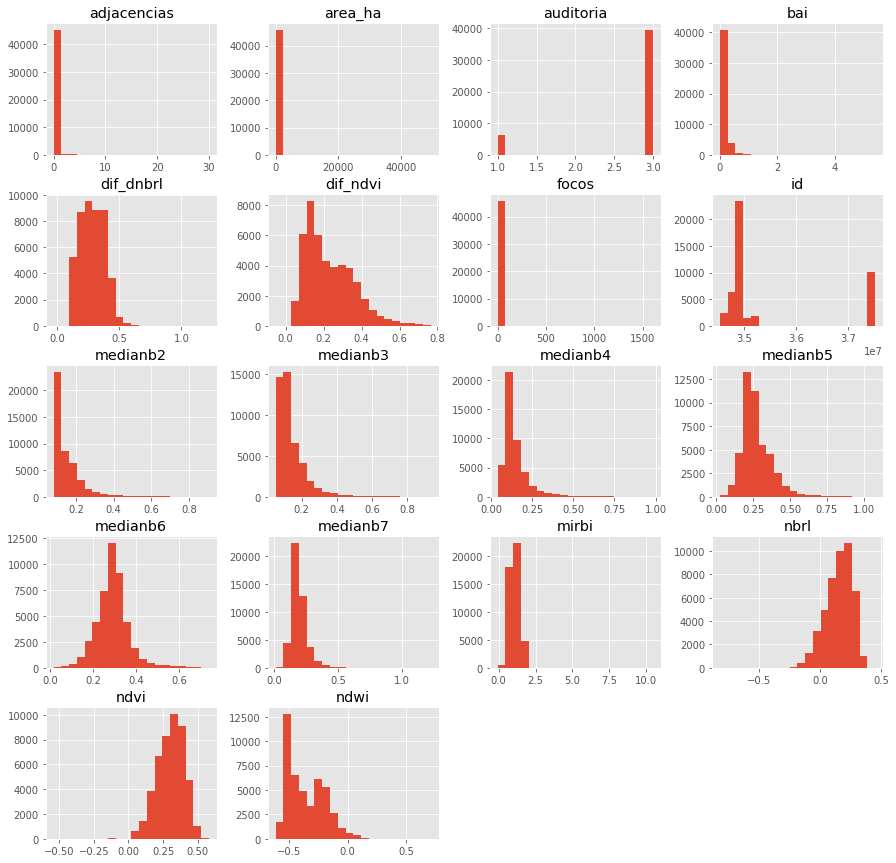

In [8]:
# Visão da distribuição geral do conjunto
# atributo-alvo: auditoria ( 1 = queimada; 3 = não queimada)
# meta: id ( identificador de cada objeto)

full.hist(bins=20, figsize=(15, 15))
plt.show()


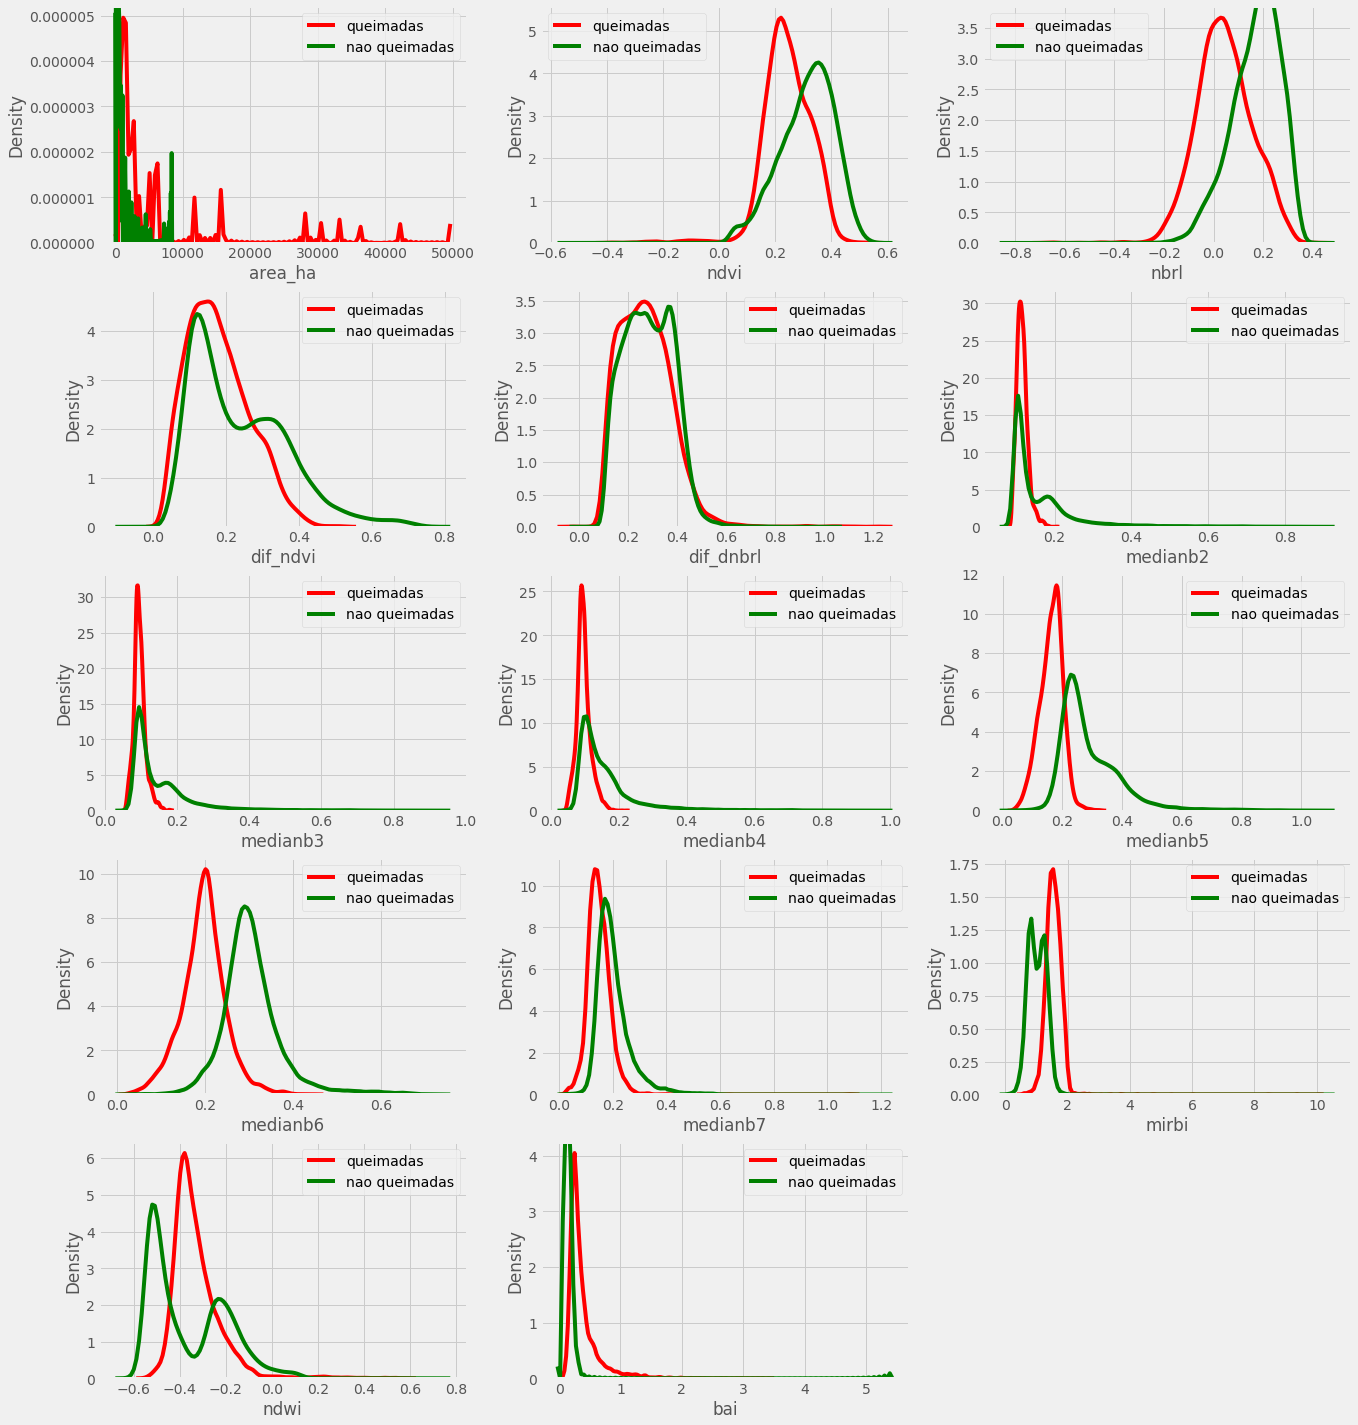

In [13]:
# Visualizar a distribuição dos conjuntos em relação à classificação

from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 3: 'green'})
burned_mapping = OrderedDict({1: 'queimadas', 3: 'nao queimadas'})

# Iterate through the float columns
for i, col in enumerate(full.select_dtypes('float')):
    ax = plt.subplot(8, 3, i + 1)
    # Iterate through the poverty levels
    for burned_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(full.loc[full['auditoria'] == burned_level, col].dropna(), 
                    ax = ax, color = color, label = burned_mapping[burned_level])
        
    #plt.title(f"{col.capitalize()} Distribution");
    plt.xlabel(col); 
    plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [8]:
# Atributos id e auditoria possuem comportamento esperado
# Atributos de medianas das bandas estão normalizados
# Atributos bai, adjacencias, focos, area_ha apresentam gráficos altamente concentrados 
# Sugerimos alguns tipos de transformações 
# numéricas que melhoraram a visualização e os cálculos.

In [9]:
def log_ajust(x):
    if (x == 0): return 0
    return np.log(x)

full['log_bai'] = (map (lambda x:log_ajust(x), full.bai))
full.drop('bai', axis=1, inplace=True) 

full['log_area'] = (map (lambda x:log_ajust(x), full.area_ha))
full.drop('area_ha', axis=1, inplace=True) 

full['log_focos'] = (map (lambda x:log_ajust(x), full.focos))
full.drop('focos', axis=1, inplace=True) 

full['log_adjac'] = (map (lambda x:log_ajust(x), full.adjacencias))
full.drop('adjacencias', axis=1, inplace=True) 


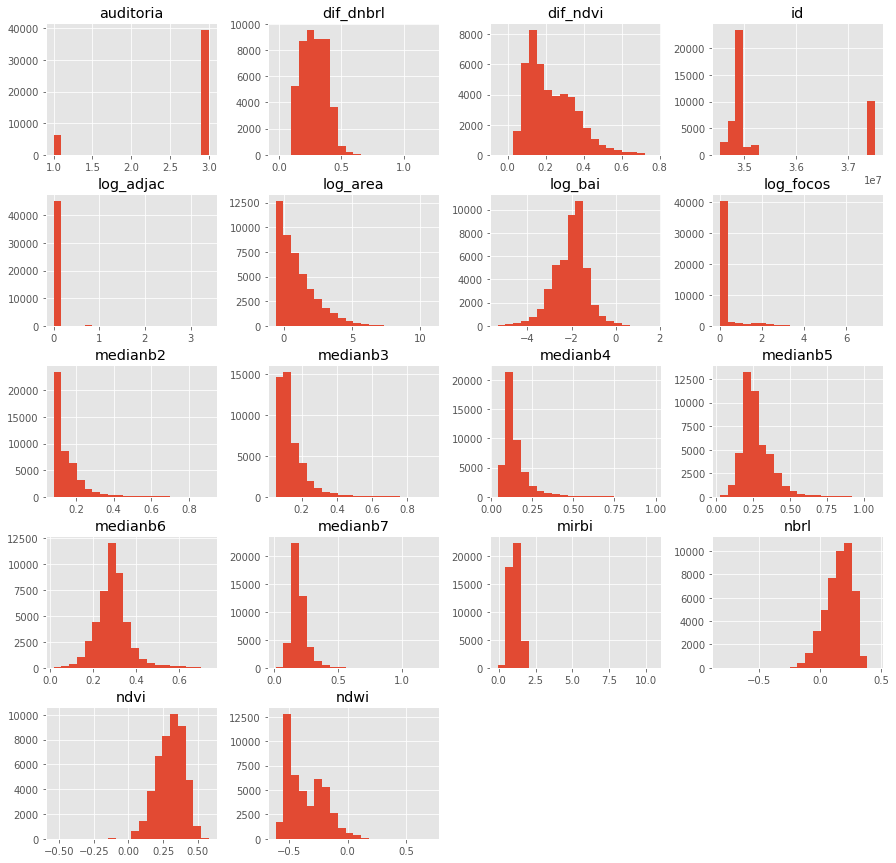

In [10]:
# Visão da distribuição geral do conjunto

full.hist(bins=20, figsize=(15, 15))
plt.show()

           auditoria  dif_dnbrl  dif_ndvi  log_adjac  log_area   log_bai  \
auditoria   1.000000   0.046215  0.159946  -0.139720 -0.098117 -0.495743   
dif_dnbrl   0.046215   1.000000  0.677189  -0.000148  0.178230 -0.293343   
dif_ndvi    0.159946   0.677189  1.000000  -0.026912  0.130882 -0.642156   
log_adjac  -0.139720  -0.000148 -0.026912   1.000000  0.134296  0.089316   
log_area   -0.098117   0.178230  0.130882   0.134296  1.000000  0.003500   
log_bai    -0.495743  -0.293343 -0.642156   0.089316  0.003500  1.000000   
log_focos  -0.502931   0.049614 -0.060387   0.204272  0.212524  0.269667   
medianb2    0.181621   0.277493  0.739902  -0.024995  0.053147 -0.820110   
medianb3    0.221241   0.264180  0.720246  -0.033347  0.037368 -0.851831   
medianb4    0.238070   0.207295  0.656624  -0.038229  0.044510 -0.852873   
medianb5    0.414477   0.323359  0.692802  -0.079138  0.011714 -0.968777   
medianb6    0.490551  -0.063692  0.210432  -0.085132  0.020776 -0.785189   
medianb7    

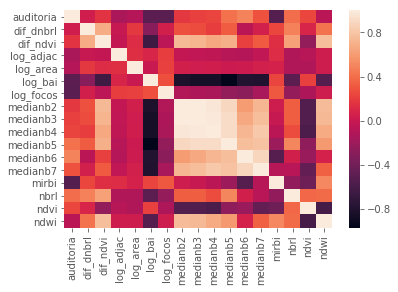

In [11]:
# Verificando as correlações entre os atributos

meta = full.columns.difference([ u'data_pas','data','id'])

corr = full[meta].corr()
print(corr)
sns.heatmap(corr, annot = False)

           auditoria  dif_dnbrl  dif_ndvi  log_adjac  log_area   log_bai  \
auditoria   1.000000   0.046215  0.159946  -0.139720 -0.098117 -0.495743   
dif_dnbrl   0.046215   1.000000  0.677189  -0.000148  0.178230 -0.293343   
dif_ndvi    0.159946   0.677189  1.000000  -0.026912  0.130882 -0.642156   
log_adjac  -0.139720  -0.000148 -0.026912   1.000000  0.134296  0.089316   
log_area   -0.098117   0.178230  0.130882   0.134296  1.000000  0.003500   
log_bai    -0.495743  -0.293343 -0.642156   0.089316  0.003500  1.000000   
log_focos  -0.502931   0.049614 -0.060387   0.204272  0.212524  0.269667   
medianb4    0.238070   0.207295  0.656624  -0.038229  0.044510 -0.852873   
medianb5    0.414477   0.323359  0.692802  -0.079138  0.011714 -0.968777   
medianb6    0.490551  -0.063692  0.210432  -0.085132  0.020776 -0.785189   
medianb7    0.289341   0.055088  0.320338  -0.031026  0.061088 -0.795209   
mirbi      -0.532989   0.242260  0.137857   0.128334  0.068638  0.232862   
nbrl        

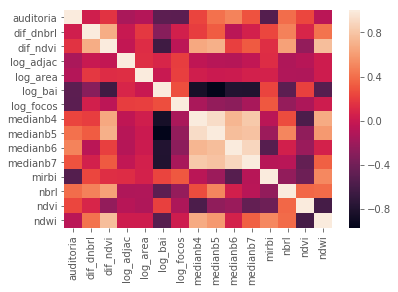

In [12]:
# Retirar atributos com correlação acima de 0.97
full.drop('medianb2',axis=1,inplace=True)
full.drop('medianb3',axis=1,inplace=True)

meta = full.columns.difference([ u'data_pas','data','id'])
corr = full[meta].corr()
print(corr)
sns.heatmap(corr, annot = False)

In [13]:
def boxs(col, title):
    y1 = full[full['auditoria'] == 1][col]
    y3 = full[full['auditoria'] == 3][col]

    trace1 = go.Box(y=y1, name="Burned", marker=dict(color="red", opacity=0.7))
    trace3 = go.Box(y=y3, name="Non burned", marker=dict(color="green", opacity=0.7))

    data = [trace1,  trace3]
    return data 
    layout = dict(title=title, showlegend=False, height=400)
    data = [trace1, trace3]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)


In [14]:
# Separando o conjunto de treinamento e o conjunto de validação

df_treinamento = full[full.data < maxdata]
df_validacao = full[full.data == maxdata]

print("Das {0} amostras, o treinamento é formado por {1} dados e o conjunto de testes é formado por {2} dados. ".
      format(full.shape[0],df_treinamento.shape[0],df_validacao.shape[0]))

print "\n*** Exemplo do conjunto de treinamento ***\n"
print df_treinamento.head(2)

print "\n*** Exemplo do conjunto de validação ***\n"
print df_validacao.head(2)


Das 45893 amostras, o treinamento é formado por 40726 dados e o conjunto de testes é formado por 5167 dados. 

*** Exemplo do conjunto de treinamento ***

         id                 data_pas      ndvi      nbrl  dif_ndvi  dif_dnbrl  \
0  37512716  2017/09/24 00:00:00.000  0.202264 -0.059606  0.144009   0.159632   
1  37513351  2017/09/24 00:00:00.000  0.215696 -0.068060  0.207591   0.358945   

   medianb4  medianb5  medianb6  medianb7  auditoria     mirbi      ndwi  \
0  0.145994  0.223395  0.327896  0.251095          3  1.297564 -0.435316   
1  0.096033  0.157605  0.221846  0.182931          1  1.655217 -0.394301   

        data   log_bai  log_area  log_focos  log_adjac  
0 2017-09-24 -1.883351  4.621818   0.000000        0.0  
1 2017-09-24 -1.111394  4.972683   2.197225        0.0  

*** Exemplo do conjunto de validação ***

            id                 data_pas      ndvi      nbrl  dif_ndvi  \
2646  37522449  2017/10/10 00:00:00.000  0.279373  0.041059  0.148521   
2647  375224

In [15]:
# Estruturar o conjunto de dados que será usado para treinar o modelo, 
# separando o 'atributo alvo' e atributos não utilizados na classificação
features = df_treinamento.columns.difference([ u'data_pas', u'auditoria','data','id'])
X_treinamento = df_treinamento[features].values
y_treinamento = df_treinamento.auditoria.values

# Estruturar o conjunto de dados que será usado para validar o modelo
# separando o 'atributo alvo' e atributos não utilizados na classificação
features_testar = df_validacao.columns.difference([ u'data_pas', u'auditoria','data','id'])
X_validacao = df_validacao[features_testar].values
y_validacao = df_validacao.auditoria.values


In [16]:
# Verificar todos os atributos utilizados como entrada dos modelos
print " *** Atributos de entrada do modelo  ***"
print df_treinamento[features_testar].columns


 *** Atributos de entrada do modelo  ***
Index([u'dif_dnbrl', u'dif_ndvi', u'log_adjac', u'log_area', u'log_bai',
       u'log_focos', u'medianb4', u'medianb5', u'medianb6', u'medianb7',
       u'mirbi', u'nbrl', u'ndvi', u'ndwi'],
      dtype='object')


# Início da Análise

In [17]:
# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier

# Evaluation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



/Users/olga/anaconda/envs/geop/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [18]:
# Definição de parâmetros dos classificadores

knn = KNeighborsClassifier(n_neighbors=3)
rf = RandomForestClassifier(random_state=1986, min_samples_leaf= 2, n_estimators= 24) 
nn = MLPClassifier(alpha= 0.00001, activation= 'relu',  max_iter= 200, hidden_layer_sizes= (100,))
lr = LogisticRegression()
stacking = StackingCVClassifier(classifiers=[rf,nn], use_probas=True, meta_classifier=lr)


In [19]:
def mostra_resultado(clf,data,pred):
    mat = confusion_matrix(data, pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    print(classification_report(data,pred))


In [20]:
def monta_resultado(clf,pos,neg,X1,y1):
   
    print ("\n Exemplo da aplicação do classificador %s na validação ***** " % (label))
    prd_clf = clf.predict(X1) 
    prd_proba_clf = clf.predict_proba(X1)

    mostra_resultado(clf,y1,prd_clf)
        
    temp = pd.DataFrame(prd_proba_clf,columns=[(label+'_'+pos),(label+'_'+neg)])
    temp[label] = pd.DataFrame(prd_clf)
    
    return temp
   

Index([], dtype='object')


 ***** Classificador : KNN ***** 

 ** Exemplo no conjunto de treinamento **


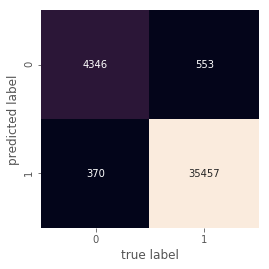

             precision    recall  f1-score   support

          1       0.89      0.92      0.90      4716
          3       0.99      0.98      0.99     36010

avg / total       0.98      0.98      0.98     40726


 Relatório de Acurácias de 10 validações cruzadas no ** Treinamento ** 
Accuracy: 0.95 (+/- 0.04) 

 Relatório de Acurácias de 10 validações cruzadas na ** Validação **
Accuracy: 0.91 (+/- 0.05) 

 Exemplo da aplicação do classificador KNN na validação ***** 


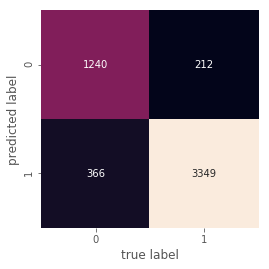

             precision    recall  f1-score   support

          1       0.85      0.77      0.81      1606
          3       0.90      0.94      0.92      3561

avg / total       0.89      0.89      0.89      5167



 ***** Classificador : RF ***** 

 ** Exemplo no conjunto de treinamento **


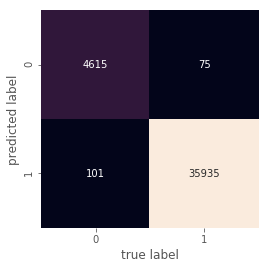

             precision    recall  f1-score   support

          1       0.98      0.98      0.98      4716
          3       1.00      1.00      1.00     36010

avg / total       1.00      1.00      1.00     40726


 Relatório de Acurácias de 10 validações cruzadas no ** Treinamento ** 
Accuracy: 0.96 (+/- 0.03) 

 Relatório de Acurácias de 10 validações cruzadas na ** Validação **
Accuracy: 0.94 (+/- 0.04) 

 Exemplo da aplicação do classificador RF na validação ***** 


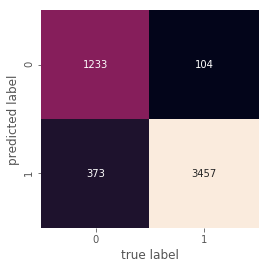

             precision    recall  f1-score   support

          1       0.92      0.77      0.84      1606
          3       0.90      0.97      0.94      3561

avg / total       0.91      0.91      0.91      5167



 ***** Classificador : NN ***** 

 ** Exemplo no conjunto de treinamento **


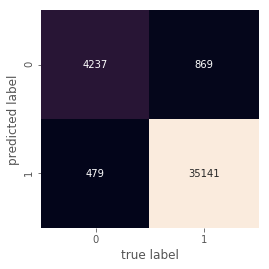

             precision    recall  f1-score   support

          1       0.83      0.90      0.86      4716
          3       0.99      0.98      0.98     36010

avg / total       0.97      0.97      0.97     40726


 Relatório de Acurácias de 10 validações cruzadas no ** Treinamento ** 
Accuracy: 0.96 (+/- 0.04) 

 Relatório de Acurácias de 10 validações cruzadas na ** Validação **
Accuracy: 0.91 (+/- 0.05) 

 Exemplo da aplicação do classificador NN na validação ***** 


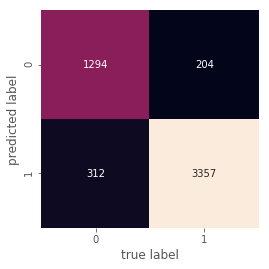

             precision    recall  f1-score   support

          1       0.86      0.81      0.83      1606
          3       0.91      0.94      0.93      3561

avg / total       0.90      0.90      0.90      5167



 ***** Classificador : ST ***** 

 ** Exemplo no conjunto de treinamento **


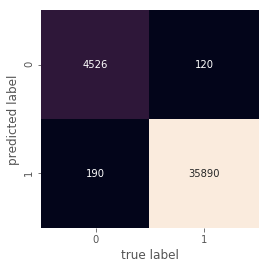

             precision    recall  f1-score   support

          1       0.97      0.96      0.97      4716
          3       0.99      1.00      1.00     36010

avg / total       0.99      0.99      0.99     40726


 Relatório de Acurácias de 10 validações cruzadas no ** Treinamento ** 
Accuracy: 0.96 (+/- 0.03) 

 Relatório de Acurácias de 10 validações cruzadas na ** Validação **
Accuracy: 0.94 (+/- 0.04) 

 Exemplo da aplicação do classificador ST na validação ***** 


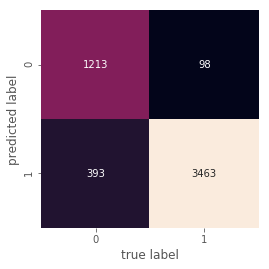

             precision    recall  f1-score   support

          1       0.93      0.76      0.83      1606
          3       0.90      0.97      0.93      3561

avg / total       0.91      0.90      0.90      5167



In [21]:
#Teste com predição do modelo 

clf_result = pd.DataFrame()
print clf_result.columns   

for clf, label in zip([ knn, rf, nn , stacking], 
                      ['KNN',
                       'RF', 
                       'NN',
                       'ST',
                        ]):

    print("\n\n ***** Classificador : %s ***** " % (label))
    
    clf.fit(X_treinamento,y_treinamento)
    
    print "\n ** Exemplo no conjunto de treinamento **"
    prd = clf.predict(X_treinamento)
    mostra_resultado(clf,y_treinamento,prd)
 
    print "\n Relatório de Acurácias de 10 validações cruzadas no ** Treinamento ** "
    scores = model_selection.cross_val_score(clf, X_treinamento, y_treinamento, scoring='accuracy', cv=10)
    print("Accuracy: %0.2f (+/- %0.2f) " % (scores.mean(), scores.std()))
 
    print "\n Relatório de Acurácias de 10 validações cruzadas na ** Validação **"
    scores2 = model_selection.cross_val_score(clf, X_validacao,y_validacao, scoring='accuracy', cv=10)
    print("Accuracy: %0.2f (+/- %0.2f) " % (scores2.mean(), scores2.std()))
 
    result = monta_resultado(clf,'1','3',X_validacao,y_validacao)
   
    temp_result = pd.concat([clf_result, result], axis=1)
    clf_result = temp_result
    
    del temp_result


In [22]:
# Os resultados apresentados incluem a classificação sugerida pelo modelo e um valor
# de estimativa de quanto aquele objeto observado se "assemelha" os objetos daquele conjunto.
# Assim, permite-se ao interessado, definir valores diferentes de <0.5 e >0.5 para 
# sugerir a que grupo cada objeto pertence

print "\n ** Exemplo resultado classificadores com estimativas ** "
print clf_result.head(5)

result = pd.concat([df_validacao.reset_index(drop=True), clf_result.reset_index(drop=True)], axis=1)

result.to_csv("./resultado_223_067_ensemble_Stacking_KNN_NN_RF.csv")


 ** Exemplo resultado classificadores com estimativas ** 
   KNN_1  KNN_3  KNN      RF_1      RF_3  RF      NN_1      NN_3  NN  \
0    1.0    0.0    1  0.319444  0.680556   3  0.630853  0.369147   1   
1    1.0    0.0    1  1.000000  0.000000   1  0.999895  0.000105   1   
2    0.0    1.0    3  0.000000  1.000000   3  0.000007  0.999993   3   
3    1.0    0.0    1  1.000000  0.000000   1  0.996113  0.003887   1   
4    0.0    1.0    3  0.000000  1.000000   3  0.000116  0.999884   3   

       ST_1      ST_3  ST  
0  0.167055  0.832945   3  
1  0.984898  0.015102   1  
2  0.006930  0.993070   3  
3  0.984772  0.015228   1  
4  0.006932  0.993068   3  


In [23]:
# Visão geral da importância de cada atributo em um modelo de árvores de decisão 

## list of features to be used
features = [c for c in full.columns if c not in [ 'data_pas', 'auditoria','data','id','ano']]

# Separar o conjunto de dados que será usado para treinar o modelo, sem o resultado
X_full = full[features].values
y_full = full.auditoria.values

features_importance = zip(rf.feature_importances_,features)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %0.2f%%" % (feature, importance*100))

log_bai: 19.90%
medianb7: 16.79%
medianb4: 12.53%
mirbi: 10.90%
log_adjac: 8.56%
medianb5: 7.41%
log_area: 6.13%
medianb6: 4.87%
ndwi: 3.35%
log_focos: 3.04%
nbrl: 3.04%
ndvi: 1.84%
dif_dnbrl: 1.61%
dif_ndvi: 0.03%


In [24]:
# Exemplo de como persistir o modelo gerado para ser utilizado posteriormente com outro
# conjunto de dados com os mesmos atributos

from sklearn.externals import joblib

# Modelo que será salvo
model_to_save = stacking
print model_to_save

# Ordem que deverá ser usada na utilização do modelo
print full[features].columns

# Já que todos os dados iniciais estavam validados e o resultado foi satisfatório
# criaremos o modelo com todos os dados de 2017 para ser usado com os dados de 2018...

model_to_save.fit(X_full,y_full)

filename = ("./model_223_067_stacking.sav")
joblib.dump(model_to_save, filename)

StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_f...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)],
           cv=2,
           meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           refit=True, shuffle=True, store_train_meta_features=False,
           stratify=True, use_features_in_secondary=False, use_probas=True,
           verbose=0)
Index([u'ndvi', u'nbrl', u'dif_ndvi', u'dif_dnbrl', u'medianb4', u'medianb5',
       u'medianb6'

['./model_223_067_stacking.sav']